## G-mode: anlalysis of temporal series in force microscopy

Code by: Marti Checa

Publication: M.Checa et. al "Simultaneous mapping of nanoscale dielectric, electrochemical, and ferroelectric surface properties of van der Waals layered ferroelectric via advanced SPM", Applied Physics Letters (2021)

## Imports

In the cell below we import important packages required below

In [1]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import os
import sys
from scipy.signal import correlate
from warnings import warn
import joblib
import h5py
from functools import partial
from scipy.signal import find_peaks

# Computation:
import numpy as np
import numpy.polynomial.polynomial as npPoly
from scipy.optimize import curve_fit


# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm


# The engineering components supporting BGlib:
import sidpy as sidpy
import pyUSID as usid
from sidpy.viz.plot_utils import set_tick_font_size, plot_curves, plot_map_stack
# Finally, BGlib itself
from BGlib import gmode as Glib
import BGlib
import pycroscopy as px

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

%precision %.4g
%gui qt

## Upload the Tunning file

In [2]:
%matplotlib inline

input_file_path = sidpy.io.interface_utils.openfile_dialog(caption='Select data',
                                        file_types='Parameters for raw G-Line data (*.dat);; \
                                        Translated file (*.h5)')

tune_path, _ = os.path.split(input_file_path)
tune_file_base_name=os.path.basename(tune_path)


if input_file_path.endswith('.h5'):
    h5_path_tuned = input_file_path
else:
    print('Translating raw data to h5. Please wait')
    tran=Glib.translators.GTuneTranslator()
    h5_path_tuned=tran.translate(input_file_path)

Translating raw data to h5. Please wait


C:\ProgramData\Anaconda3\lib\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '


Note: 7 of 256 lines found in data file


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1081: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')


(7, 4194304)
(7, 4194304)
(7, 4194304)
(7, 4194304)


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Reading line 0 of 7
Finished reading file: F:\ORNL\Experimental data\Cypher West\2021\September 2021\210914\TUNE_GMode_CIPS_IPS__0001_incomplete\TUNE_GMode_CIPS_IPS__0001_bigtime_00.dat!
(7, 4194304)
(7, 4194304)
(7, 4194304)
(7, 4194304)
Reading line 0 of 7
Finished reading file: F:\ORNL\Experimental data\Cypher West\2021\September 2021\210914\TUNE_GMode_CIPS_IPS__0001_incomplete\TUNE_GMode_CIPS_IPS__0001_bigtime_01.dat!
G-Tune translation complete!


## Calculate the transfer function of the cantilever

<ipython-input-3-b3cbba2f50de>:49: RuntimeWarning: divide by zero encountered in true_divide
  TF_vec = Yt0_tune/F0


Calculating the transfer function...


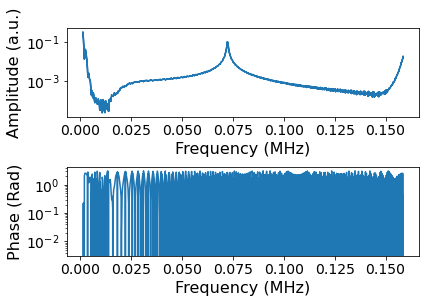

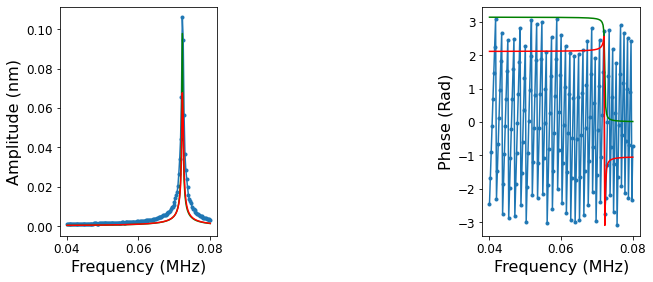

C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1081: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')


(1, 4194304)
(1, 4194304)


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Text(0, 0.5, 'Modelled Transfer Function (a.u.)')

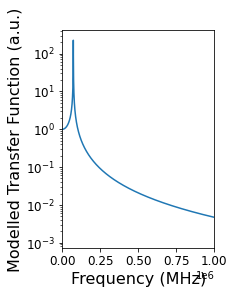

In [3]:
    ##############################################################
    ##Step 1b. Extract the Resonance Modes Considered in the Force Reconstruction
    ##############################################################

    #define number of eigenmodes to consider
num_bandsVal=1

    #define bands (center frequency +/- bandwith)
MB0_w1 = 60E3 - 20E3
MB0_w2 = 60E3 + 20E3

MB1_w1 = 100E3 - 200E3
MB1_w2 = 100E3 + 200E3

  
MB1_amp = 30E-9
MB2_amp = 1E-9

MB_parm_vec = np.array([MB1_amp,MB0_w1,MB0_w2,MB1_amp,MB1_w1,MB1_w2])
MB_parm_vec.resize(2,3)
band_edge_mat = MB_parm_vec[:,1:3]

h5_file = h5py.File(h5_path_tuned, 'r+')

h5_tune_resp = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]
h5_tune = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[-1]

samp_rate = (usid.hdf_utils.get_attr(h5_tune.parent.parent, 'IO_rate_[Hz]'))
num_rows=h5_tune.pos_dim_sizes[0]
N_points_per_line=h5_tune.spec_dim_sizes[0]
N_points_per_pixel=N_points_per_line / num_rows
w_vec2 = np.linspace(-0.5 * samp_rate, 0.5 * samp_rate - 1.0*samp_rate / N_points_per_line, N_points_per_line)
dt = 1/samp_rate
df = 1/dt

# Response
A_pd = np.mean(h5_tune_resp, axis=0)
yt0_tune = A_pd - np.mean(A_pd)
Yt0_tune = np.fft.fftshift(np.fft.fft(yt0_tune,N_points_per_line)*dt)

# Excitation
h5_spec_vals = usid.hdf_utils.get_auxiliary_datasets(h5_tune, aux_dset_name='Spectroscopic_Values')[0]
BE_pd = h5_spec_vals[0, :]

f0 = BE_pd - np.mean(BE_pd)
F0 = np.fft.fftshift(np.fft.fft(f0,N_points_per_line)*dt)
excited_bin_ind = np.where(np.abs(F0)>0.5e-3)

TF_vec = Yt0_tune/F0

plt.figure(2)
plt.subplot(2,1,1)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.abs(TF_vec[excited_bin_ind]))
plt.tick_params(labelsize=14)
plt.xlabel('Frequency (MHz)',fontsize=16)
plt.ylabel('Amplitude (a.u.)',fontsize=16)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.subplot(2,1,2)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.angle(TF_vec[excited_bin_ind]))
plt.tick_params(labelsize=14)
#plt.ylim([1E-4, 1E+1]) # Beth added this line
#plt.xlim([0,1]) # Beth added this line
plt.xlabel('Frequency (MHz)',fontsize=16)
plt.ylabel('Phase (Rad)',fontsize=16)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)


    ##############################################################
    ##Step 1c. Construct an effective Transfer function (TF_Norm) from SHO fits
    ##############################################################

TunePhase = -np.pi
num_bands = band_edge_mat.shape[0]
coef_mat = np.zeros((num_bands,4))
coef_guess_vec = np.zeros((4))
TF_fit_vec = np.zeros((w_vec2.shape))
TFb_vec = TF_vec[excited_bin_ind]
wb = w_vec2[excited_bin_ind]


for k1 in range(num_bandsVal):
        print('Calculating the transfer function...')
    # locate the fitting region
    w1 = band_edge_mat[k1][0]
    w2 = band_edge_mat[k1][1]
    bin_ind1 = np.where(np.abs(w1-wb) == np.min(np.abs(w1-wb)))[0][0]
    bin_ind2 = np.where(np.abs(w2-wb) == np.min(np.abs(w2-wb)))[0][0]
    response_vec = TFb_vec[bin_ind1:bin_ind2+1].T
    wbb = wb[bin_ind1:bin_ind2+1].T/1E+6

    if k1 == 0:
        Q_guess = 300
        #Q_guess = 50

    elif k1 == 1:
        Q_guess = 500
        # Q_guess = 150
    else:
        Q_guess = 700
        #  Q_guess = 75

    response_mat = np.array([np.real(response_vec), np.imag(response_vec)]).T
    A_max_ind = np.argmax(np.abs(response_vec))
    A_max = response_vec[A_max_ind]
    A_guess = A_max/Q_guess
    wo_guess = wbb[A_max_ind]

    if k1 == 0:
        phi_guess = TunePhase

    coef_guess_vec[0] = np.real(A_guess)
    coef_guess_vec[1] = wo_guess
    coef_guess_vec[2] = Q_guess
    coef_guess_vec[3] = phi_guess

    LL_vec = [0,w1/1E+6,1,np.pi] # lower limit
    UL_vec = [float("inf"),w2/1E+6,10000,-np.pi] # upper limit

    coef_vec = BGlib.be.analysis.utils.be_sho.SHOestimateGuess(response_vec,wbb,10)

    response_guess_vec = BGlib.be.analysis.utils.be_sho.SHOfunc(coef_guess_vec,wbb)
    response_fit_vec = BGlib.be.analysis.utils.be_sho.SHOfunc(coef_vec,wbb)

    coef_vec[1] = coef_vec[1]*1E6
    coef_mat[k1,:] = coef_vec

    response_fit_full_vec = BGlib.be.analysis.utils.be_sho.SHOfunc(coef_vec,w_vec2)

    TF_fit_vec = TF_fit_vec + response_fit_full_vec # check for length and dimension


    plt.figure(10, figsize=(12, 4))
    plt.subplot(1, 4, k1+1)
    plt.plot(wbb,np.abs(response_vec),'.-')
    plt.plot(wbb,np.abs(response_guess_vec),c='g')
    plt.plot(wbb,np.abs(response_fit_vec),c='r')
    plt.tick_params(labelsize=12)
    plt.xlabel('Frequency (MHz)', fontsize=16)
    plt.ylabel('Amplitude (nm)', fontsize=16)
    
    plt.subplot(1, 4, (k1+1)+2)
    plt.plot(wbb,np.angle(response_vec),'.-')
    plt.plot(wbb,np.angle(response_guess_vec),c='g')
    plt.plot(wbb,np.angle(response_fit_vec),c='r')
    plt.tick_params(labelsize=12)
    
    plt.xlabel('Frequency (MHz)', fontsize=16)
    plt.ylabel('Phase (Rad)', fontsize=16)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()
    
    if k1 == 0:
        response_fit_vec_1 = response_fit_vec
        wbb1 = wbb
    if k1 == 1:
        response_fit_vec_2 = response_fit_vec
        wbb2 = wbb

Q = coef_mat[0,2]
TF_norm = ((TF_fit_vec- np.min(np.abs(TF_fit_vec)))/np.max(np.abs(TF_fit_vec))- np.min(np.abs(TF_fit_vec)))*Q
#print(TF_norm)

tf_grp = usid.hdf_utils.create_indexed_group(h5_tune.parent.parent, 'Tune_Function')
tf_pos_dim = usid.hdf_utils.Dimension('Single Step', 'a.u.', 1)
tf_spec_dim = usid.hdf_utils.Dimension('Frequency', 'MHz', w_vec2)
h5_tf = usid.hdf_utils.write_main_dataset(tf_grp, TF_norm.reshape(1, -1), 'Tune_Data', 
                                               'Response', 'a.u.',
                                               tf_pos_dim, tf_spec_dim)

h5_file.close()

plt.subplot(1, 2, 1)
plt.plot(w_vec2,np.abs(TF_norm))
plt.tick_params(labelsize=12)
plt.yscale("log")
plt.xlim(0,1e6)
plt.xlabel('Frequency (MHz)', fontsize=16)
plt.ylabel('Modelled Transfer Function (a.u.)', fontsize=16)

## Save the transfer function if wanted

In [4]:
print(np.abs(TF_norm))
#We save the cantilever transfer function
os.chdir(r'F:\ORNL\Experimental data\Cypher West\2021\September 2021\210914')
np.savetxt("frequency transfer function.txt",w_vec2, delimiter = ",")
np.savetxt("transfer function.txt",np.abs(TF_norm), delimiter = ",")
print('Saved!')

[0.00134176 0.00134176 0.00134176 ... 0.00134214 0.00134214 0.00134214]
Saved!


# Upload Image data and convert to .H5 file format.

In [5]:
input_file_path = sidpy.io.interface_utils.openfile_dialog(caption='Select data',
                                    file_types='Parameters for raw G-Line data (*.dat);; \
                                    Translated file (*.h5)')
folder_path, _ = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    h5_path = input_file_path
    print('Working on:\n' + h5_path)   



else:
    print('Translating raw data to h5. Please wait')
    tran = Glib.translators.GLineTranslator()
    h5_path = tran.translate(input_file_path)

Translating raw data to h5. Please wait
Note: 253 of 256 lines found in data file


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1081: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')


(253, 4194304)
(253, 4194304)
(253, 4194304)
(253, 4194304)


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Reading line 0 of 253
Reading line 10 of 253
Reading line 20 of 253
Reading line 30 of 253
Reading line 40 of 253
Reading line 50 of 253
Reading line 60 of 253
Reading line 70 of 253
Reading line 80 of 253
Reading line 90 of 253
Reading line 100 of 253
Reading line 110 of 253
Reading line 120 of 253
Reading line 130 of 253
Reading line 140 of 253
Reading line 150 of 253
Reading line 160 of 253
Reading line 170 of 253
Reading line 180 of 253
Reading line 190 of 253
Reading line 200 of 253
Reading line 210 of 253
Reading line 220 of 253
Reading line 230 of 253
Reading line 240 of 253
Reading line 250 of 253
Finished reading file: F:\ORNL\Experimental data\Cypher West\2021\September 2021\210914\70 deg\210914GMode_CIPS_IPS__0005\GMode_CIPS_IPS__0005_bigtime_00.dat!
(253, 4194304)
(253, 4194304)
(253, 4194304)
(253, 4194304)
Reading line 0 of 253
Reading line 10 of 253
Reading line 20 of 253
Reading line 30 of 253
Reading line 40 of 253
Reading line 50 of 253
Reading line 60 of 253
Reading 

#### Extract some relevant parameters

In [6]:
img_length=20e6
img_height=10e6

hdf = h5py.File(h5_path, 'r+')

h5_main = usid.hdf_utils.find_dataset(hdf,'Raw_Data')[0]
(basename, parm_paths, data_paths) = Glib.translators.GLineTranslator._parse_file_path(input_file_path)


matread = loadmat(parm_paths['parm_mat'], variable_names=['BE_wave_AO_0', 'BE_wave_AO_1', 'total_cols', 'total_rows'])
#pulse_wave = np.float32(np.squeeze(matread['BE_wave_AO_1'])) 

h5_pos_vals=h5_main.h5_spec_vals 
h5_pos_inds=h5_main.h5_spec_inds
h5_spec_vals = h5_main.h5_spec_vals 
h5_spec_inds = h5_main.h5_spec_inds 

samp_rate = (usid.hdf_utils.get_attr(h5_main.parent.parent, 'IO_rate_[Hz]'))

num_rows=h5_main.pos_dim_sizes[0]
N_points_per_line=h5_main.spec_dim_sizes[0]
N_points_per_pixel=N_points_per_line / num_rows

# General parameters
parms_dict = h5_main.parent.parent.attrs
samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']
num_rows = parms_dict['grid_num_rows']
num_cols = parms_dict['grid_num_cols']

num_pts = h5_main.shape[1]
pnts_per_pix=int(num_pts/num_cols)


# Adding image size to the parameters
parms_dict['FastScanSize'] = img_length
parms_dict['SlowScanSize'] = img_height

N_points = parms_dict['num_bins']
N_points_per_pixel = parms_dict['num_bins']
time_per_osc = (1/parms_dict['BE_center_frequency_[Hz]'])
IO_rate = parms_dict['IO_rate_[Hz]']     #sampling_rate
parms_dict['sampling_rate'] = IO_rate
pnts_per_period = IO_rate * time_per_osc #points per oscillation period
pxl_time = N_points_per_pixel/IO_rate    #seconds per pixel
num_periods = int(pxl_time/time_per_osc) #total # of periods per pixel, should be an integer

# Excitation waveform for a single pixel
pixel_ex_wfm = h5_spec_vals[0, :int(h5_spec_vals.shape[1]/num_cols)]

#pixel_ex_wfm = np.float32(np.squeeze(matread['BE_wave'])) 

# Excitation waveform for a single line / row of data
excit_wfm = h5_spec_vals.value

# Preparing the frequency axis:
w_vec = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/num_pts, num_pts)
w_vec_pix = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/pnts_per_pix, pnts_per_pix)

# Preparing the time axis:
t_vec_line = 1E3*np.linspace(0, num_pts/samp_rate, num_pts)
t_vec_pix = 1E3*np.linspace(0, pnts_per_pix/samp_rate, pnts_per_pix)

# Dimension objects
rows_vals = np.linspace(0, img_height, num_rows)
cols_vals = np.linspace(0, img_length, num_cols)
time_vals = t_vec_pix
dt = 1/samp_rate
# Correctly adds the ancillary datasets
pos_dims = [usid.write_utils.Dimension('Cols', 'm', cols_vals),
            usid.write_utils.Dimension('Rows', 'm', rows_vals)]
spec_dims = [usid.write_utils.Dimension('Time', 's', time_vals)]

<ipython-input-6-017794a84098>:54: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  excit_wfm = h5_spec_vals.value


Text(0, 0.5, 'Vac')

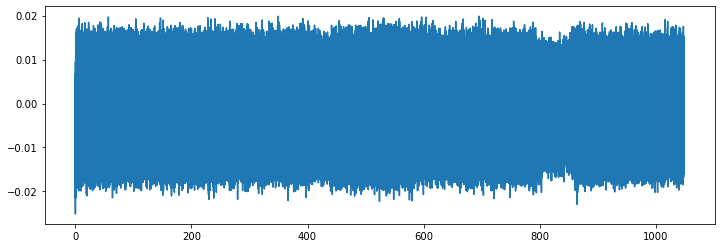

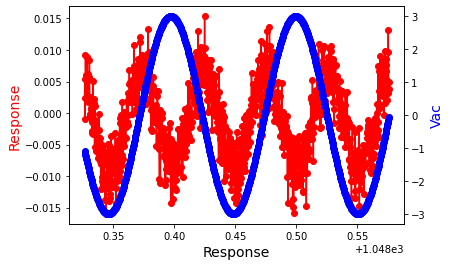

In [7]:
%matplotlib inline
row_ind =14 #row of data you want to look at
data_line1 = h5_main[row_ind][:]

### Lets look at a single line of data
plt.figure(10, figsize=(12, 4))
plt.plot(t_vec_line,data_line1)

fig,ax = plt.subplots()
# make a plot
ax.plot(t_vec_line[-1000:],data_line1[-1000:], color="red", marker="o")
ax.set_xlabel("Response",fontsize=14)
# set y-axis label
ax.set_ylabel("Response",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(t_vec_line[-1000:],pixel_ex_wfm[-1000:], color="blue", marker="o")
ax2.set_xlabel("Vac",fontsize=14)
# set y-axis label
ax2.set_ylabel("Vac",color="blue",fontsize=14)
#plt.plot(filt_linetest[-200:])

Text(0, 0.5, 'Magnitude')

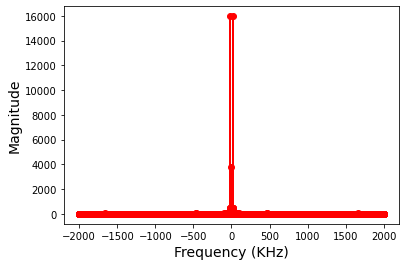

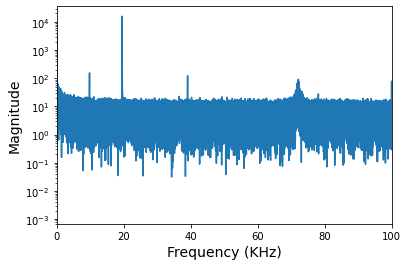

In [8]:
##Lets look at what the data looks like in the Fourier Domain
Fdata= np.fft.fftshift(np.fft.fft(data_line1))

fig,ax = plt.subplots()
# make a plot
ax.plot(w_vec,np.abs(Fdata) , color="red", marker="o")
ax.set_xlabel("Frequency (KHz)",fontsize=14)
ax.set_ylabel("Magnitude",fontsize=14)

##Lets just plot the real part and confine the frequency range
fig,ax = plt.subplots()
# make a plot
ax.plot(w_vec,np.abs(Fdata))
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_xlabel("Frequency (KHz)",fontsize=14)
ax.set_ylabel("Magnitude",fontsize=14)

## Save the line data we are plotting

In [9]:
#We save the data stream
os.chdir(r'F:\ORNL\Experimental data\Cypher West\2021\September 2021\210914')
np.savetxt("time.txt",t_vec_line[-1000:], delimiter = ",")
np.savetxt("resposnse.txt",data_line1[-1000:], delimiter = ",")
np.savetxt("excitation.txt",pixel_ex_wfm[-1000:], delimiter = ",")
np.savetxt("frequency.txt",w_vec, delimiter = ",")
np.savetxt("FFT.txt",np.abs(Fdata), delimiter = ",")

## Filter the data in the Fourier Domain

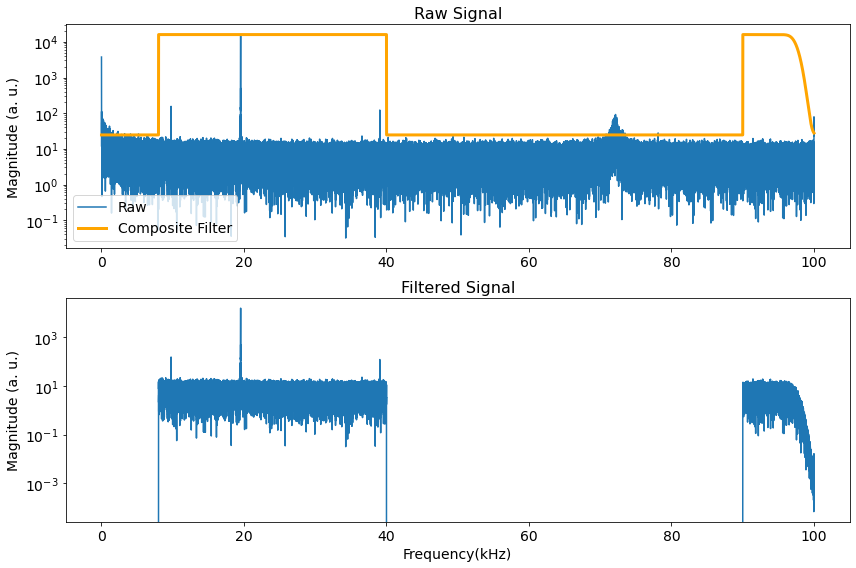

In [10]:
### Now lets try to filter the data in the Fourier Domain. Im going to use the filters from pycroscopy but you can play with building you own if you wish

num_spectral_pts = h5_main.shape[1]
    
##############################################################################################################################
#### Here you can play with Low Pass Filter
################################################################################################################
lpf = px.processing.fft.LowPassFilter(num_pts, samp_rate, 100E+3) # low pass filter

##############################################################################################################################
#### Here you can play with Noise band filter
################################################################################################################
nbf = px.processing.fft.NoiseBandFilter(num_pts, samp_rate, [65E+3, 2E+3], [50E+3,12E+3])
################################################################################################################################
#### Here you can play with Noise Noise tolerance
################################################################################################################

noise_tolerance = 200E-9
noise_tolerance = None
freq_filts = [lpf, nbf]

 
  
excit_wfm = h5_spec_vals[-1]


filt_line, fig_filt, axes_filt = px.processing.gmode_utils.test_filter(h5_main[row_ind], 
                                                                   frequency_filters=freq_filts, 
                                                                   noise_threshold=noise_tolerance, 
                                                                   show_plots=True)



## We plot the filtered response in the time domain

Text(0, 0.5, 'Response (Filtered)')

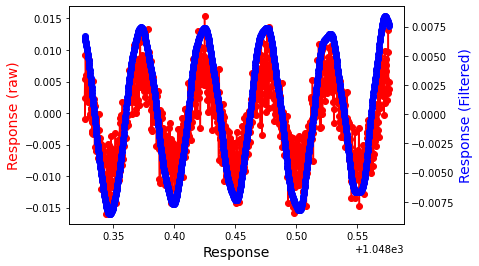

In [11]:
fig,ax = plt.subplots()
# make a plot
ax.plot(t_vec_line[-1000:],data_line1[-1000:], color="red", marker="o")
ax.set_xlabel("Response",fontsize=14)
# set y-axis label
ax.set_ylabel("Response (raw)",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(t_vec_line[-1000:],filt_line[-1000:], color="blue", marker="o")
ax2.set_xlabel("Vac",fontsize=14)
# set y-axis label
ax2.set_ylabel("Response (Filtered)",color="blue",fontsize=14)

## We save the filtered data

In [12]:
#We save the data stream
os.chdir(r'F:\ORNL\Experimental data\Cypher West\2021\September 2021\210914')
np.savetxt("time.txt",t_vec_line[-1000:], delimiter = ",")
np.savetxt("resposnse.txt",data_line1[-1000:], delimiter = ",")
np.savetxt("excitation.txt",pixel_ex_wfm[-1000:], delimiter = ",")
np.savetxt("filt response.txt",filt_line[-1000:], delimiter = ",")
np.savetxt("frequency.txt",w_vec, delimiter = ",")
np.savetxt("FFT.txt",np.abs(Fdata), delimiter = ",")


## Digital Lockin Amplifier of the G-mode data stream

In [13]:
def DigitalLIA1(h5_dset,drive_vec,w_vec2,num_rows,num_cols,ex_freq):
    
    AmpMat=np.zeros((num_rows,num_cols))
    PhaseMat=np.zeros((num_rows,num_cols))
    AmpMat2=np.zeros((num_rows,num_cols))
    PhaseMat2=np.zeros((num_rows,num_cols))
    AmpMat3=np.zeros((num_rows,num_cols))
    PhaseMat3=np.zeros((num_rows,num_cols))
    AmpMat4=np.zeros((num_rows,num_cols))
    PhaseMat4=np.zeros((num_rows,num_cols))
    
    ind_drive = (np.abs(w_vec2*10**3-(ex_freq))).argmin()
    ind_drive2 = (np.abs(w_vec2*10**3-(2*ex_freq))).argmin()
    ind_drive3 = (np.abs(w_vec2*10**3-(3*ex_freq))).argmin()
    ind_drive4 = (np.abs(w_vec2*10**3-(4*ex_freq))).argmin()
    
    print('Drive Frequency: {} '.format(w_vec2[ind_drive]))
    F_Drive = np.fft.fftshift(np.fft.fft(drive_vec))
    row_indx=10
    col_indx=0
    for row_indx in range(num_rows):
        col_indx=0
        if row_indx % 10 == 0:
            print('Reading line {} of {}'.format(row_indx, num_rows))

        data_vec = h5_dset[row_indx][:]
        data_vec = data_vec-np.mean(data_vec)   
        data_vec = np.reshape(data_vec,[num_cols,-1])
           
        for col_indx in range(num_cols):
            test_pix=np.squeeze(data_vec[col_indx,:])
            
            #fig = plt.figure()
            #ax = fig.add_subplot(1, 1, 1)
            #ax.plot(t_vec_pix,test_pix)
            #ax2=ax.twinx()
            #ax2.plot(t_vec_pix,pixel_ex_wfm,'r')
            #ax.set_xlim(0, 0.25)
            #plt.show()
            
            F_resp = np.fft.fftshift(np.fft.fft(test_pix)/len(test_pix))
            #F_resp = F_resp[range(int(len(test_pix)/2))]
            
            #tpCount     = len(test_pix)
            #values      = np.arange(int(tpCount))
            #samplingFrequency = 1/samp_rate
            #timePeriod  = tpCount/samplingFrequency
            #frequencies = values/timePeriod
            
            #print('Fresp=',np.sqrt(2)*abs(F_resp[ind_drive2]))
            #fig = plt.figure()
            #ax = fig.add_subplot(1, 1, 1)
            #ax.plot(w_vec2,abs(F_resp))
            #ax.scatter(2*ex_freq/1e3,abs(F_resp[ind_drive2]))
            #ax.set_xlim(0, 100)
            #ax.set_yscale('log')
            #plt.show()
            #time.sleep(2)
            AmpMat[row_indx, col_indx]= np.sqrt(2)*np.abs(F_resp[(ind_drive)])
            PhaseMat[row_indx, col_indx]= np.angle(F_resp[(ind_drive)])
            AmpMat2[row_indx, col_indx]= np.sqrt(2)*np.abs(F_resp[(ind_drive2)])
            PhaseMat2[row_indx, col_indx]= np.angle(F_resp[(ind_drive2)])
            AmpMat3[row_indx, col_indx]= np.sqrt(2)*np.abs(F_resp[(ind_drive3)])
            PhaseMat3[row_indx, col_indx]= np.angle(F_resp[(ind_drive3)])
            AmpMat4[row_indx, col_indx]= np.sqrt(2)*np.abs(F_resp[(ind_drive4)])
            PhaseMat4[row_indx, col_indx]= np.angle(F_resp[(ind_drive4)])           
                
    return AmpMat, PhaseMat, AmpMat2, PhaseMat2, AmpMat3, PhaseMat3, AmpMat4, PhaseMat4

    print('Finished reading file')

In [14]:
Amp, Phase, Amp2, Phase2, Amp3, Phase3, Amp4, Phase4= DigitalLIA1(h5_main,pixel_ex_wfm,w_vec_pix ,num_rows,num_cols,ex_freq)

#Here we translate the units.
#Parameters:
k=3 # in nN/nm
m=0.0200   # in V/nm
Vefm=3 # in Volts

Factor_dCdZ=(4*k)/((Vefm**2)*(m))

# For the dC/dz to aF/nm
AmpVolts=Amp
Amp=Factor_dCdZ*Amp

Amp2Volts=Amp2
Amp2=Factor_dCdZ*Amp2

# For the Phase to degrees

Phase=np.rad2deg(Phase)
Phase2=np.rad2deg(Phase2)
Phase3=np.rad2deg(Phase3)
Phase4=np.rad2deg(Phase4)

Drive Frequency: 9.765625 
Reading line 0 of 253
Reading line 10 of 253
Reading line 20 of 253
Reading line 30 of 253
Reading line 40 of 253
Reading line 50 of 253
Reading line 60 of 253
Reading line 70 of 253
Reading line 80 of 253
Reading line 90 of 253
Reading line 100 of 253
Reading line 110 of 253
Reading line 120 of 253
Reading line 130 of 253
Reading line 140 of 253
Reading line 150 of 253
Reading line 160 of 253
Reading line 170 of 253
Reading line 180 of 253
Reading line 190 of 253
Reading line 200 of 253
Reading line 210 of 253
Reading line 220 of 253
Reading line 230 of 253
Reading line 240 of 253
Reading line 250 of 253


Text(0.5, 1.0, 'Amp 2w')

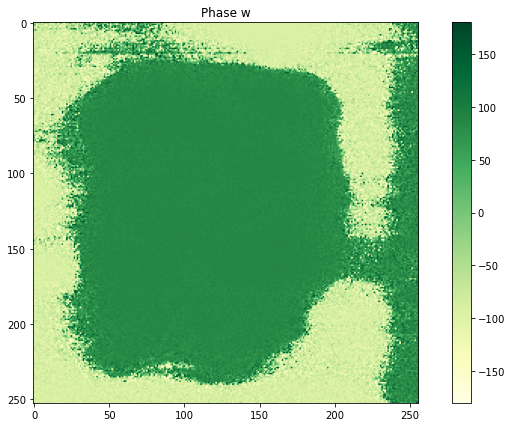

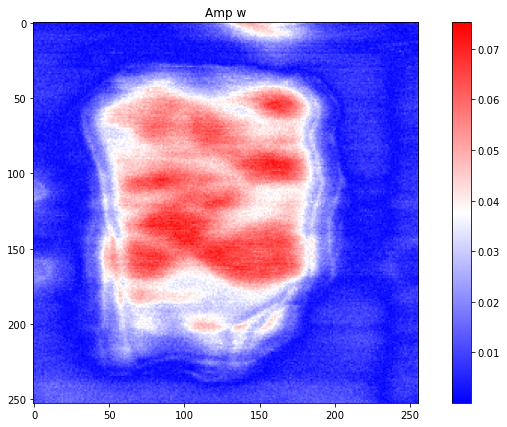

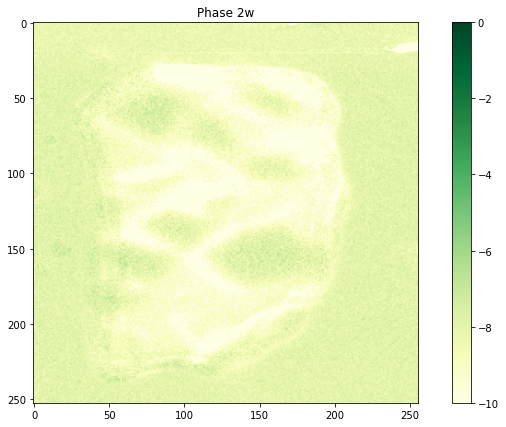

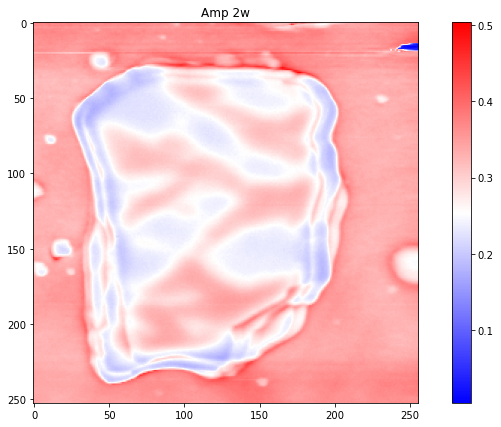

In [32]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
plt.imshow(np.flipud(np.fliplr(Phase)), cmap='YlGn')
plt.colorbar()
plt.title('Phase w')
#plt.clim(0,3.14)

fig, ax = plt.subplots(figsize=(12, 7))
plt.imshow(np.flipud(np.fliplr(Amp)), cmap='bwr')
plt.colorbar()
plt.title('Amp w')
#plt.clim(0e-9,0.25e-9)

#plt.savefig(output_filepath+'\LIA_IDS.tif', format='tiff')

fig1, ax1 = plt.subplots(figsize=(12, 7))
plt.imshow(np.flipud(np.fliplr(Phase2)), cmap='YlGn')
plt.colorbar()
plt.title('Phase 2w')
plt.clim(0,-10)

fig, ax = plt.subplots(figsize=(12, 7))
plt.imshow(np.flipud(np.fliplr(Amp2)), cmap='bwr')
plt.colorbar()
plt.title('Amp 2w')
#plt.clim(0.3e-9,0.6e-9)

## OL-KPFM calculation from the G mode data

Gw= 1.0192827201936567
G2w= 1.0793264855800655
Xgain= 0.9443692282283435


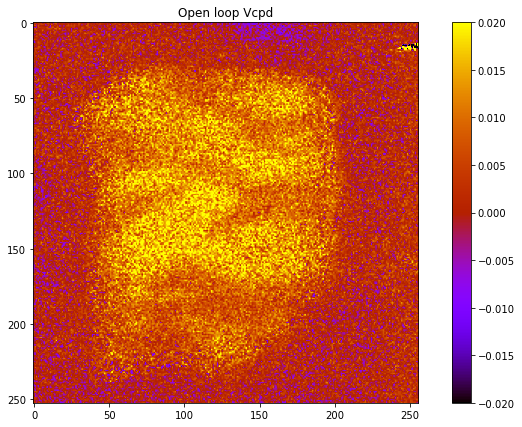

In [44]:
#Open loop KPFM
Vac=3
Vdc=0

ind_w1=(np.abs(w_vec2 - (ex_freq))).argmin()
ind_w2=(np.abs(w_vec2 - (2*ex_freq))).argmin()
        
Xgain=np.max(np.abs(TF_norm[ind_w1]))/np.max(np.abs(TF_norm[ind_w2]))

print('Gw=',np.abs(TF_norm[ind_w1]))
print('G2w=',np.abs(TF_norm[ind_w2]))
print('Xgain=',Xgain)
      
OL_Vcpd=(Vac*AmpVolts*np.cos(np.deg2rad(Phase))/(Xgain*4*Amp2Volts))+Vdc

fig1, ax1 = plt.subplots(figsize=(12, 7))
plt.imshow(np.flipud(np.fliplr(OL_Vcpd)), cmap='gnuplot',vmin=-0.1,vmax=0.1)
plt.title('Open loop Vcpd')
plt.colorbar()
plt.clim(0.02,-0.02)
plt.show()

#np.savetxt('OLKPFM.txt', OL_Vcpd , delimiter="\t")
#print('OL-KPFM saved!')

## Save the generated images

In [45]:
#We save the 2w and KPFM images in txt
os.chdir(r'F:\ORNL\Experimental data\Cypher West\2021\September 2021\210914')
np.savetxt("Phase_2w_110.txt",Phase2, delimiter = "\t")
np.savetxt("Amplitude_2w_110.txt",Amp2, delimiter = "\t")
np.savetxt("AmplitudeVolts_2w_110.txt",Amp2Volts, delimiter = "\t")

np.savetxt("Phase_2w_PVDF.txt",Phase2, delimiter = ",")
np.savetxt("Amplitude_2w.txt",Amp2, delimiter = ",")
np.savetxt("Phase_3w.txt",Phase3, delimiter = ",")
np.savetxt("Amplitude_3w.txt",Amp3, delimiter = ",")
np.savetxt("Phase_4w.txt",Phase4, delimiter = ",")
np.savetxt("Amplitude_4w.txt",Amp4, delimiter = ",")
np.savetxt("OL_KPFM.txt",np.fliplr(OL_Vcpd), delimiter = ",")